# USPTO-680K(Molscribe dataset) 필터링 및 전처리

# 단일 분자 구조만 포함되도록 필터링

In [1]:
import pandas as pd
import os
from typing import List, Dict, Tuple, Optional
from rdkit import Chem
import numpy as np
from tqdm import tqdm

In [3]:

class SingleMoleculeFilter:
    """MOL 파일 기반으로 단일 분자 구조만 필터링"""
    
    def __init__(self):
        pass
    
    def is_single_molecule(self, mol_file_path: str) -> bool:
        """
        MOL 파일이 단일 분자 구조인지 확인
        
        Args:
            mol_file_path: MOL 파일 경로
            
        Returns:
            bool: 단일 분자면 True, 아니면 False
        """
        if not os.path.exists(mol_file_path):
            return False
        
        try:
            # MOL 파일 읽기
            mol = Chem.MolFromMolFile(mol_file_path, sanitize=True)
            
            if mol is None:
                # sanitize 실패시 재시도
                mol = Chem.MolFromMolFile(mol_file_path, sanitize=False)
                if mol is None:
                    return False
            
            # 핵심 조건: 분자 조각이 1개인가?
            fragments = Chem.GetMolFrags(mol)
            if len(fragments) != 1:
                return False
            
            # 핵심 조건: 모든 원자가 연결되어 있는가?
            if not self._is_connected(mol):
                return False
            
            return True
            
        except:
            return False
    
    def _is_connected(self, mol) -> bool:
        """분자가 연결되어 있는지 확인"""
        if mol.GetNumAtoms() <= 1:
            return True
        
        try:
            # 인접 행렬로 연결성 확인
            adj_matrix = Chem.GetAdjacencyMatrix(mol)
            num_atoms = mol.GetNumAtoms()
            
            # DFS
            visited = set([0])
            stack = [0]
            
            while stack:
                node = stack.pop()
                for i in range(num_atoms):
                    if adj_matrix[node][i] and i not in visited:
                        visited.add(i)
                        stack.append(i)
            
            return len(visited) == num_atoms
        except:
            return False
    
    def filter_csv(self, csv_path: str, sample_size: Optional[int] = None) -> pd.DataFrame:
        """
        CSV 파일에서 단일 분자만 필터링
        
        Args:
            csv_path: CSV 파일 경로
            sample_size: 처리할 행 수 (None이면 전체)
            
        Returns:
            단일 분자만 포함된 DataFrame
        """
        # CSV 읽기
        df = pd.read_csv(csv_path)
        
        if sample_size and sample_size < len(df):
            df = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
        
        print(f"Processing {len(df)} entries...")
        
        # mol_path 컬럼 확인
        if 'mol_path' not in df.columns:
            raise ValueError("CSV must contain 'mol_path' column")
        
        # 필터링
        single_molecules = []
        
        for idx, row in tqdm(df.iterrows(), total=len(df)):
            mol_path = row['mol_path']
            
            if pd.isna(mol_path):
                continue
            
            # 단일 분자인지 확인
            if self.is_single_molecule(mol_path):
                single_molecules.append(row.to_dict())
        
        result_df = pd.DataFrame(single_molecules)
        
        print(f"Found {len(result_df)} single molecules out of {len(df)} total")
        print(f"Success rate: {len(result_df)/len(df)*100:.1f}%")
        
        return result_df
    
    def save_results(self, filtered_df: pd.DataFrame, output_path: str):
        """결과 저장"""
        filtered_df.to_csv(output_path, index=False)
        print(f"Saved {len(filtered_df)} single molecules to {output_path}")

# 사용 예시
def main():
    filter_instance = SingleMoleculeFilter()
    
    # 필터링 실행
    result_df = filter_instance.filter_csv(
        csv_path="uspto_mol/train_680k.csv",
        sample_size=None  # 1000개만 테스트
    )
    
    # 결과 저장
    if len(result_df) > 0:
        filter_instance.save_results(result_df, "uspto_mol/single_molecules.csv")
    else:
        print("No single molecules found!")

if __name__ == "__main__":
    main()

Processing 680220 entries...


100%|██████████| 680220/680220 [00:22<00:00, 30108.26it/s]

Found 0 single molecules out of 680220 total
Success rate: 0.0%
No single molecules found!


# 좌표 확인

In [4]:
import pandas as pd
df = pd.read_csv('uspto_mol/single_molecules.csv')
df_samp = df.sample(30, random_state=42)


In [5]:
df_samp.head()

,file_path,mol_path,raw_SMILES,SMILES,node_coords,edges
267529,uspto_mol/2005/I20050104/US06838576-20050104/U...,uspto_mol/2005/I20050104/US06838576-20050104/U...,[1*]C([H])=C,[1*]C([H])=[PR23],"[[-0.7145,-0.6187],[-0.0,-0.2062],[-0.0,0.6187...","[[0,1,1],[1,3,2],[1,2,1]]"
131499,uspto_mol/2008/I20080422/US07361671-20080422/U...,uspto_mol/2008/I20080422/US07361671-20080422/U...,[C-]#[N+]CC1=C(C)SC(CO)=C1,[C-]#[N+]CC1=C(C)SC(CO)=C1,"[[-2.3279,0.9267],[-1.531,0.7131],[-0.7331,0.9...","[[10,3,1],[3,4,2],[4,6,1],[6,7,1],[7,10,2],[4,..."
113211,uspto_mol/2005/I20050816/US06929897-20050816/U...,uspto_mol/2005/I20050816/US06929897-20050816/U...,CC(C)(COC(=O)C1C[Si](C)(C)O[Si](C)(C)C1)CC1C(=...,CC(C)(COC(=O)C1C[Si](C)(C)O[Si](C)(C)C1)CC1C(=...,"[[-1.9924,2.268],[-1.278,1.8555],[-1.4915,2.65...","[[7,16,1],[16,13,1],[13,12,1],[12,9,1],[9,8,1]..."
353138,uspto_mol/2004/20041207/US06828276-20041207/US...,uspto_mol/2004/20041207/US06828276-20041207/US...,[C-]#[N+][C+]1([CH2-])CCCCC1C1=CC=CC=C1,[C-]#[N+][C+]1([CH2-])CCCCC1C1=CC=CC=C1,"[[-1.7531,-0.1762],[-0.9281,-0.1762],[-0.513,0...","[[8,7,1],[7,6,1],[6,5,1],[5,4,1],[4,2,1],[2,8,..."
74610,uspto_mol/2006/I20060822/US07094911-20060822/U...,uspto_mol/2006/I20060822/US07094911-20060822/U...,O=C(NC1=CC(C2=CC=C(S(=O)(=O)NC(CC3=CC=CC=C3)C(...,O=C(NC1=CC(C2=CC=C(S(=O)(=O)NC(CC3=CC=CC=C3)C(...,"[[2.658,-2.0343],[2.658,-1.2093],[1.9435,-0.79...","[[19,20,1],[20,21,2],[21,16,1],[16,17,2],[17,1..."


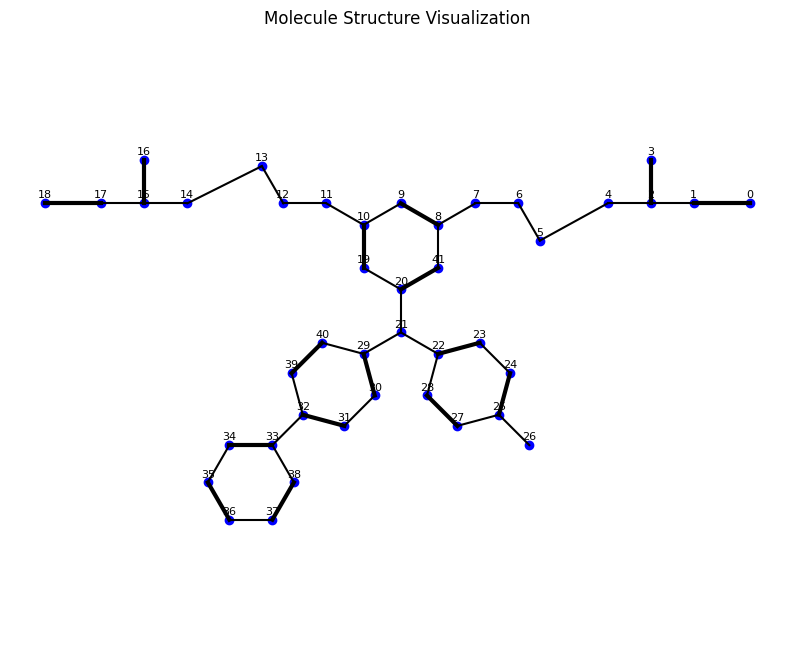

In [ ]:
import matplotlib.pyplot as plt

# 노드 좌표 리스트 (x, y)
node_coords = [[6.7569,2.6208],[5.6804,2.6208],[4.8554,2.6208],[4.8554,3.4458],[4.0304,2.6208],[2.7308,1.9063],[2.3183,2.6208],[1.4933,2.6208],[0.7788,2.2083],[0.0644,2.6208],[-0.6501,2.2083],[-1.3646,2.6208],[-2.1896,2.6208],[-2.6021,3.3352],[-4.0313,2.6208],[-4.8563,2.6208],[-4.8563,3.4458],[-5.6813,2.6208],[-6.7569,2.6208],[-0.6501,1.3833],[0.0644,0.9708],[0.0644,0.1458],[0.7788,-0.2667],[1.5757,-0.0532],[2.1591,-0.6366],[1.9456,-1.4335],[2.5289,-2.0168],[1.1487,-1.647],[0.5653,-1.0636],[-0.6501,-0.2667],[-0.4366,-1.0636],[-1.0199,-1.647],[-1.8168,-1.4335],[-2.4002,-2.0168],[-3.2252,-2.0168],[-3.6377,-2.7313],[-3.2252,-3.4458],[-2.4002,-3.4458],[-1.9877,-2.7313],[-2.0304,-0.6366],[-1.447,-0.0532],[0.7788,1.3833]]
# 엣지 리스트 [start_idx, end_idx, bond_type]
edge = [[11,10,1],[10,19,2],[19,20,1],[20,41,2],[41,8,1],[8,9,2],[9,10,1],[8,7,1],[20,21,1],[21,22,1],[21,29,1],[29,40,1],[40,39,2],[39,32,1],[32,31,2],[31,30,1],[30,29,2],[22,28,1],[28,27,2],[27,25,1],[25,24,2],[24,23,1],[23,22,2],[25,26,1],[32,33,1],[4,2,1],[2,3,2],[2,1,1],[1,0,2],[14,15,1],[15,16,2],[15,17,1],[17,18,2],[33,34,2],[34,35,1],[35,36,2],[36,37,1],[37,38,2],[38,33,1],[11,12,1],[14,13,1],[13,12,1],[7,6,1],[4,5,1],[6,5,1]]
# bond_type에 따른 선 굵기 또는 스타일
bond_styles = {
    1: {'linewidth': 1.5, 'color': 'black'},  # 단일 결합
    2: {'linewidth': 3, 'color': 'black'},    # 이중 결합 (굵게 표시)
    # 필요하면 삼중 결합 등 추가 가능
}

plt.figure(figsize=(10, 8))

# 노드 그리기
for i, (x, y) in enumerate(node_coords):
    plt.plot(x, y, 'o', color='blue')  # 노드를 파란색 원으로 표시
    plt.text(x, y+0.1, str(i), fontsize=8, ha='center')  # 노드 번호 표시

# 엣지 그리기
for start, end, bond_type in edges:
    x_values = [node_coords[start][0], node_coords[end][0]]
    y_values = [node_coords[start][1], node_coords[end][1]]
    style = bond_styles.get(bond_type, {'linewidth': 1, 'color': 'gray'})
    plt.plot(x_values, y_values, **style)

plt.axis('equal')
plt.axis('off')
plt.title("Molecule Structure Visualization")
plt.show()


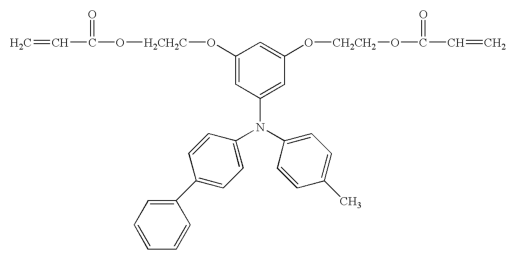

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# C=CC(=O)OCCOC1=CC(OCCOC(=O)C=C)=CC(N(C2=CC=C(C)C=C2)C2=CC=C(C3=CC=CC=C3)C=C2)=C1
# C=CC(=O)OCCOC1=CC(OCCOC(=O)C=C)=CC(N(C2=CC=C(C)C=C2)C2=CC=C(C3=CC=CC=C3)C=C2)=C1

# 이미지 파일 경로
image_path = 'uspto_mol/2008/I20080429/US07364824-20080429/US07364824-20080429-C00016.TIF'

# 이미지 열기
img = Image.open(image_path)

# 이미지 표시
plt.imshow(img)
plt.axis('off')  # 축을 표시하지 않도록
plt.show()


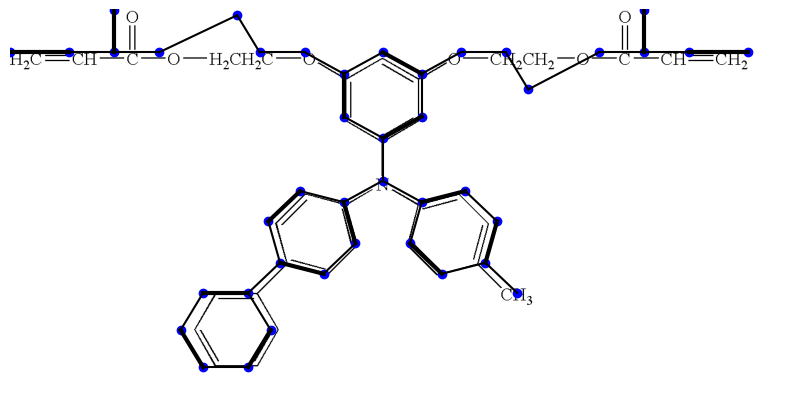

In [70]:
import matplotlib.pyplot as plt
from PIL import Image

# 이미지 경로
image_path = 'uspto_mol/2008/I20080429/US07364824-20080429/US07364824-20080429-C00016.TIF'

# 노드 좌표 리스트 (x, y)
node_coords = [[6.7569,2.6208],[5.6804,2.6208],[4.8554,2.6208],[4.8554,3.4458],[4.0304,2.6208],[2.7308,1.9063],[2.3183,2.6208],[1.4933,2.6208],[0.7788,2.2083],[0.0644,2.6208],[-0.6501,2.2083],[-1.3646,2.6208],[-2.1896,2.6208],[-2.6021,3.3352],[-4.0313,2.6208],[-4.8563,2.6208],[-4.8563,3.4458],[-5.6813,2.6208],[-6.7569,2.6208],[-0.6501,1.3833],[0.0644,0.9708],[0.0644,0.1458],[0.7788,-0.2667],[1.5757,-0.0532],[2.1591,-0.6366],[1.9456,-1.4335],[2.5289,-2.0168],[1.1487,-1.647],[0.5653,-1.0636],[-0.6501,-0.2667],[-0.4366,-1.0636],[-1.0199,-1.647],[-1.8168,-1.4335],[-2.4002,-2.0168],[-3.2252,-2.0168],[-3.6377,-2.7313],[-3.2252,-3.4458],[-2.4002,-3.4458],[-1.9877,-2.7313],[-2.0304,-0.6366],[-1.447,-0.0532],[0.7788,1.3833]]
# 엣지 리스트 [start_idx, end_idx, bond_type]
edges = [[11,10,1],[10,19,2],[19,20,1],[20,41,2],[41,8,1],[8,9,2],[9,10,1],[8,7,1],[20,21,1],[21,22,1],[21,29,1],[29,40,1],[40,39,2],[39,32,1],[32,31,2],[31,30,1],[30,29,2],[22,28,1],[28,27,2],[27,25,1],[25,24,2],[24,23,1],[23,22,2],[25,26,1],[32,33,1],[4,2,1],[2,3,2],[2,1,1],[1,0,2],[14,15,1],[15,16,2],[15,17,1],[17,18,2],[33,34,2],[34,35,1],[35,36,2],[36,37,1],[37,38,2],[38,33,1],[11,12,1],[14,13,1],[13,12,1],[7,6,1],[4,5,1],[6,5,1]]

# bond_type에 따른 선 굵기 또는 스타일
bond_styles = {
    1: {'linewidth': 1.5, 'color': 'black'},  # 단일 결합
    2: {'linewidth': 3, 'color': 'black'},    # 이중 결합 (굵게 표시)
}

# 이미지 열기
img = Image.open(image_path)

# 이미지 크기 가져오기
img_width, img_height = img.size

# 노드 좌표를 이미지 크기에 맞게 스케일링
scaled_coords = []
for x, y in node_coords:
    # x, y를 이미지의 크기에 맞춰 0~1 범위로 정규화하고, 그 후 이미지 크기에 맞게 변환
    scaled_x = (x - min(x for x, y in node_coords)) / (max(x for x, y in node_coords) - min(x for x, y in node_coords)) * img_width
    # y축 반전 (이미지의 y좌표계와 맞추기 위해)
    scaled_y = (y - min(y for x, y in node_coords)) / (max(y for x, y in node_coords) - min(y for x, y in node_coords)) * img_height
    scaled_coords.append([scaled_x, img_height - scaled_y])  # y축 반전

# 이미지에 그리기
plt.figure(figsize=(10, 8))
plt.imshow(img)

# 노드 그리기
for x, y in scaled_coords:
    plt.plot(x, y, 'o', color='blue')  # 노드를 파란색 원으로 표시

# 엣지 그리기
for start, end, bond_type in edges:
    start_pos = scaled_coords[start]
    end_pos = scaled_coords[end]
    style = bond_styles.get(bond_type, {'linewidth': 1, 'color': 'gray'})
    plt.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], **style)

plt.axis('off')  # 축 제거
plt.show()



[1*]C([H])=[PR23]
uspto_mol/2005/I20050104/US06838576-20050104/US06838576-20050104-C00001.MOL


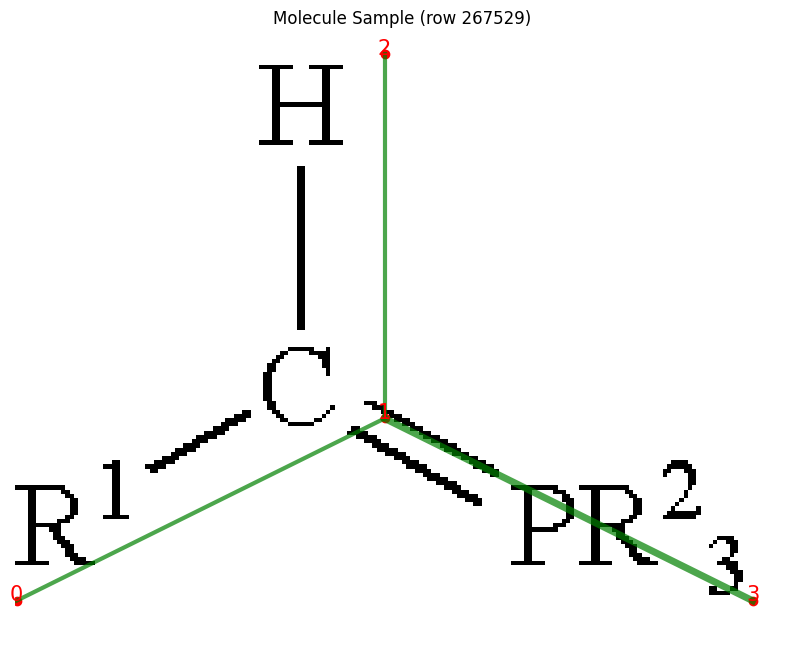

[C-]#[N+]CC1=C(C)SC(CO)=C1
uspto_mol/2008/I20080422/US07361671-20080422/US07361671-20080422-C00124.MOL


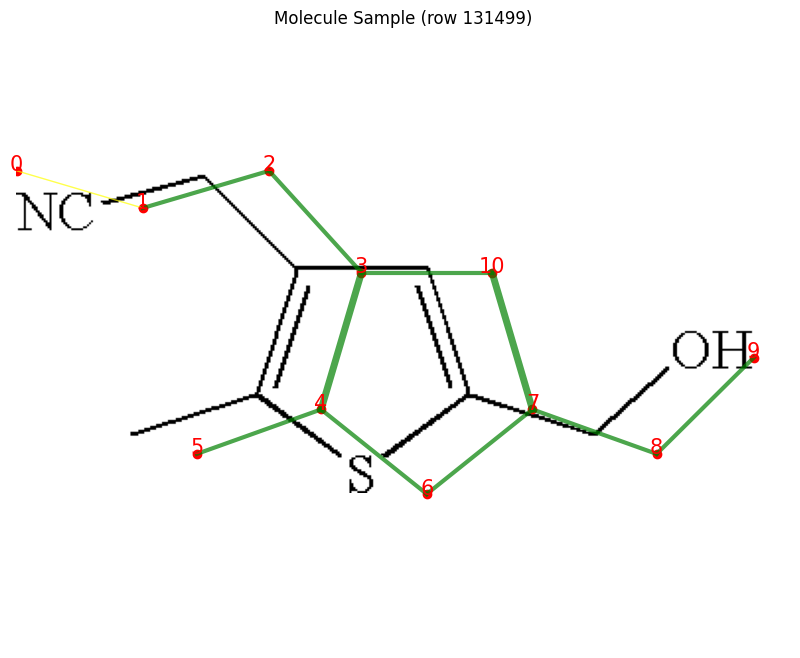

CC(C)(COC(=O)C1C[Si](C)(C)O[Si](C)(C)C1)CC1C(=O)OC(=O)C1CC(C)(C)C(=O)OC(C)(C)C
uspto_mol/2005/I20050816/US06929897-20050816/US06929897-20050816-C00024.MOL


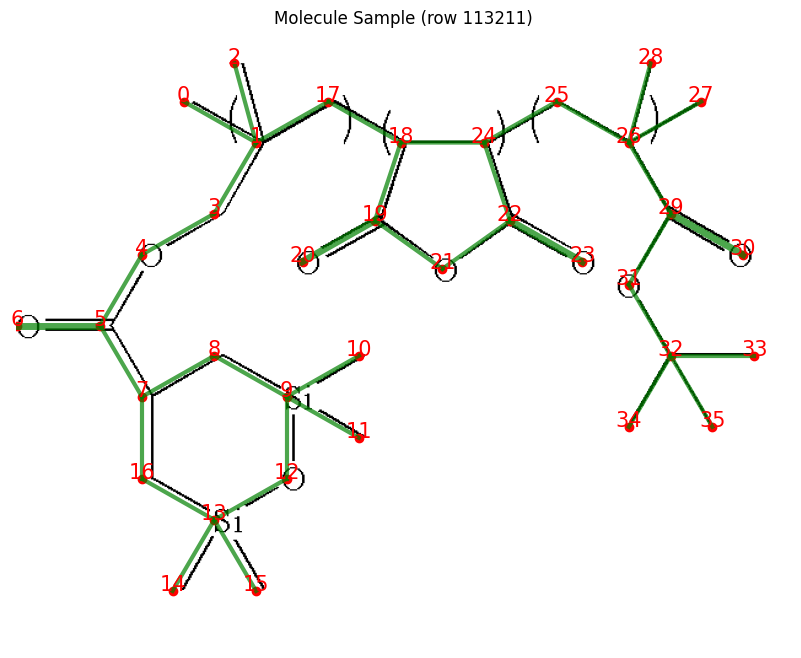

[C-]#[N+][C+]1([CH2-])CCCCC1C1=CC=CC=C1
uspto_mol/2004/20041207/US06828276-20041207/US06828276-20041207-C00026.MOL


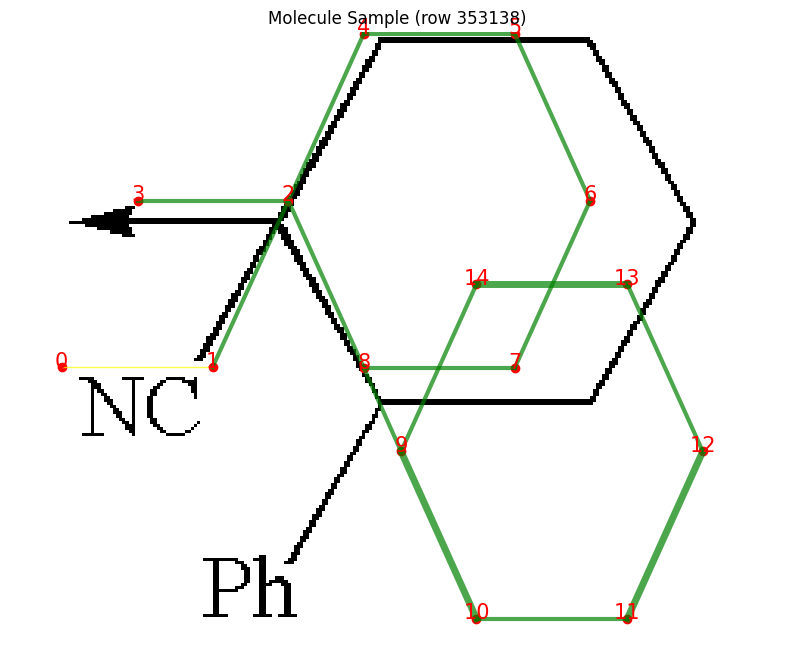

O=C(NC1=CC(C2=CC=C(S(=O)(=O)NC(CC3=CC=CC=C3)C(=O)O)C=C2)=CC=C1)NC1=NC2=C(C=CC=C2)N1
uspto_mol/2006/I20060822/US07094911-20060822/US07094911-20060822-C00286.MOL


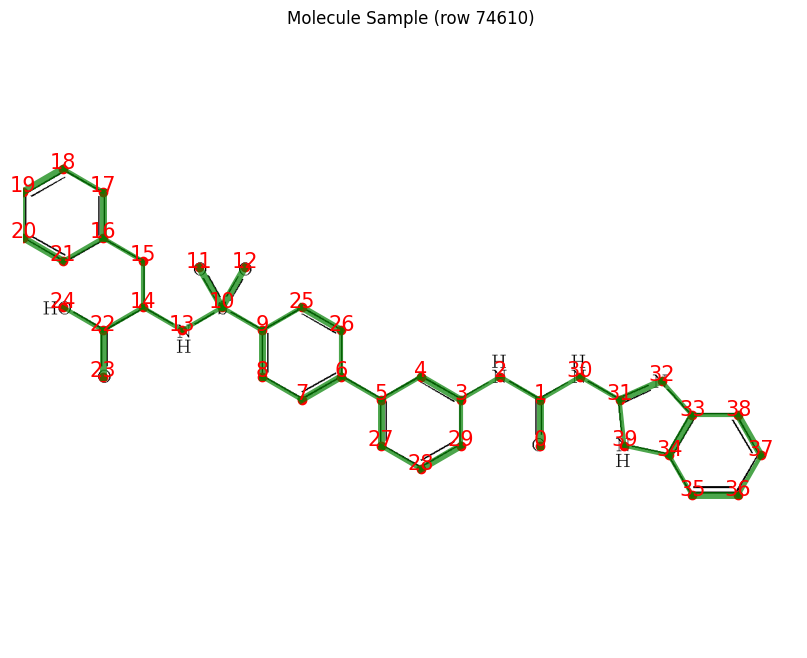

[1*]N1C=NC=N1
uspto_mol/2002/20020716/US06420406-20020716/US06420406-20020716-C00295.MOL


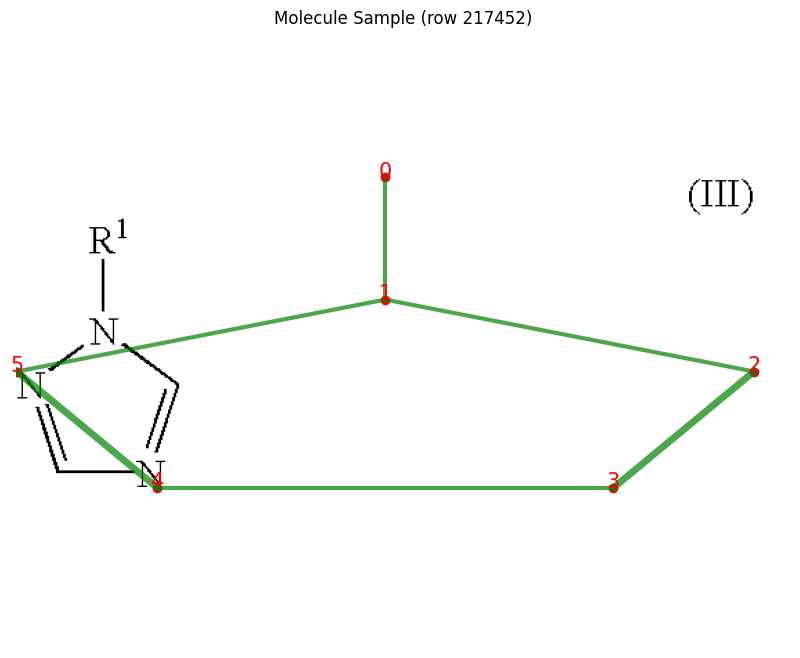

COC1CCC(O)(C#N)CC1
uspto_mol/2002/20021015/US06465222-20021015/US06465222-20021015-C00007.MOL


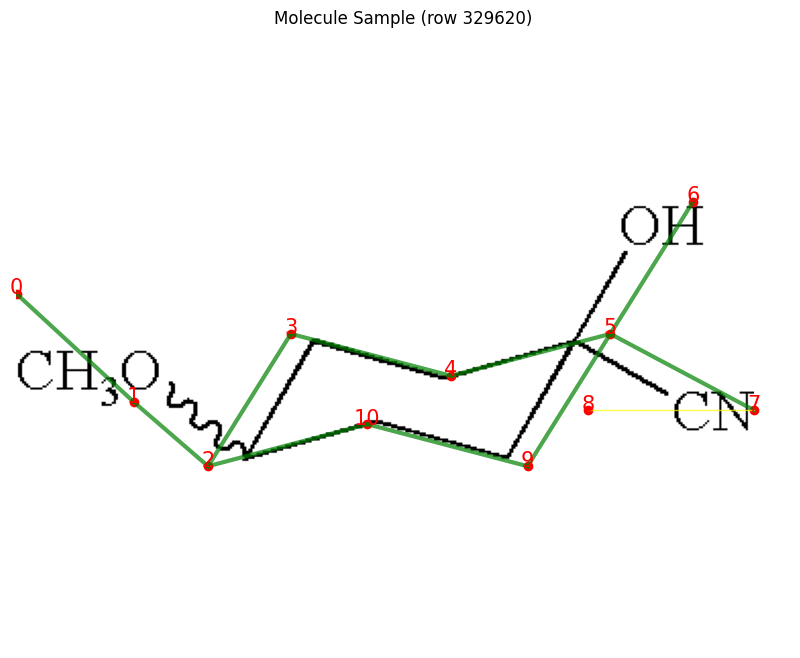

CNCC1(O)COC2=CC=CC=C2OC1
uspto_mol/2007/I20070320/US07192946-20070320/US07192946-20070320-C00033.MOL


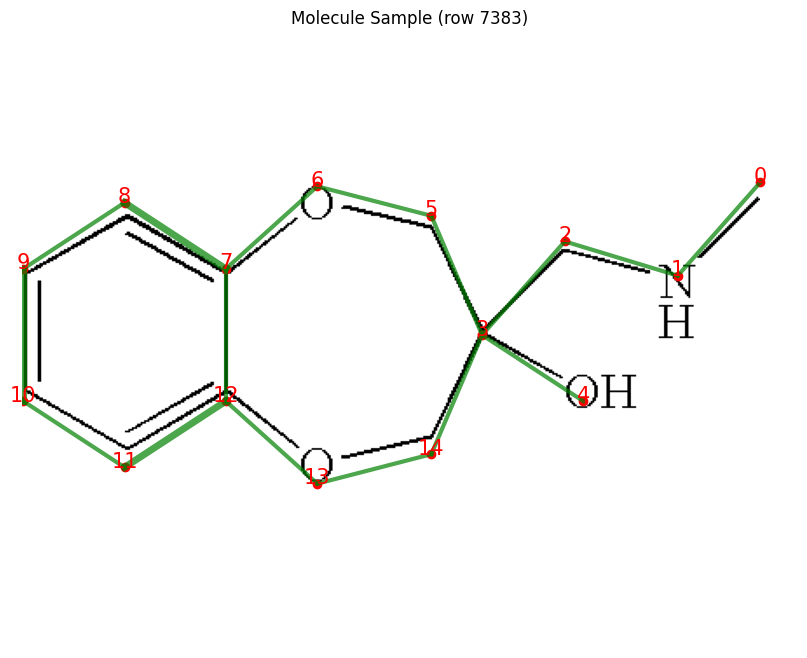

FC1=CC2=C(C=C1)NN=C2NC1=NC(C2=CC=CC=C2C(F)(F)F)=CC(C2CCCCC2)=N1
uspto_mol/2003/20031028/US06638926-20031028/US06638926-20031028-C00601.MOL


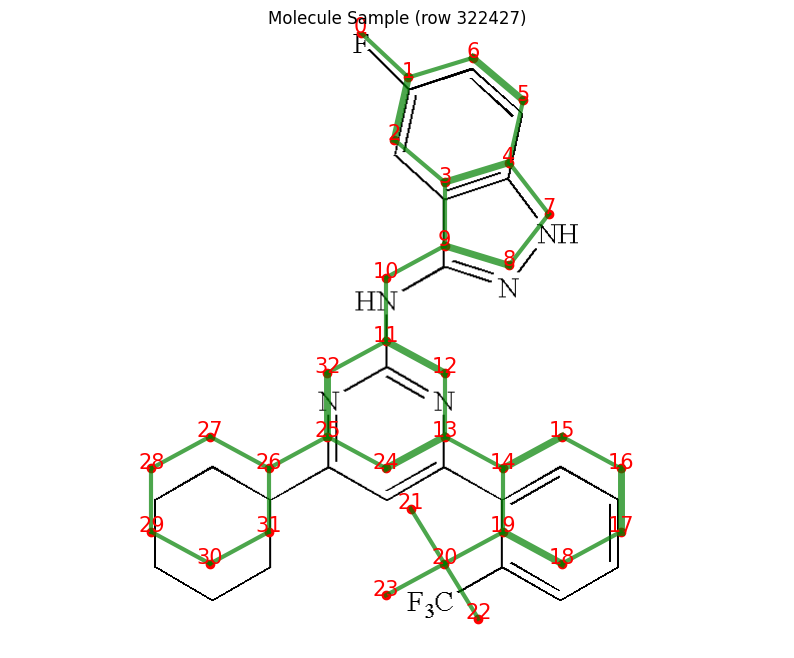

CC1=C(C(=O)NC2=CC=C3NN=CC3=C2)C(C2=CC=C(Cl)C=C2)CC(=O)N1C
uspto_mol/2009/I20090922/US07592357-20090922/US07592357-20090922-C00060.MOL


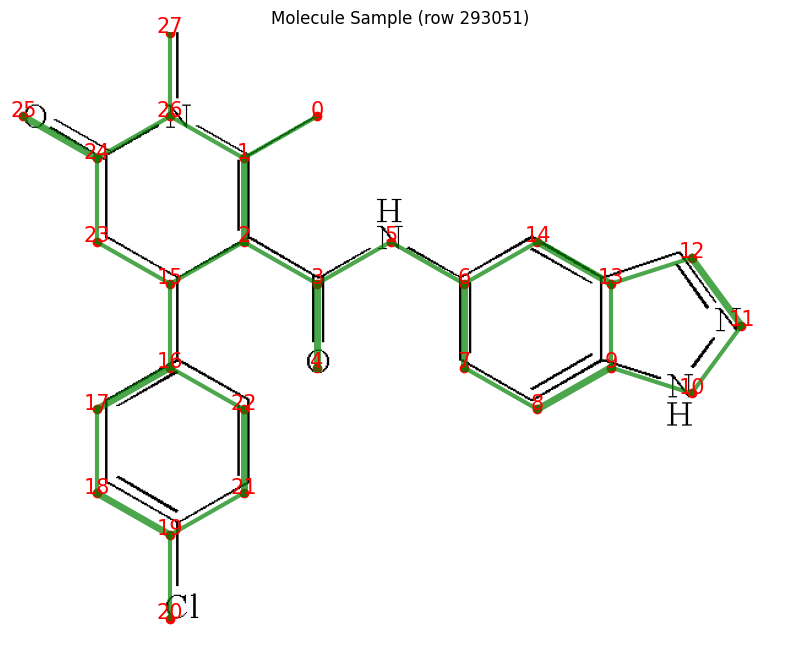

[3*]C1(COC[Y])CC(C2=C(Cl)C=NC(C)=C2Cl)=NO1
uspto_mol/2008/I20080603/US07381687-20080603/US07381687-20080603-C00044.MOL


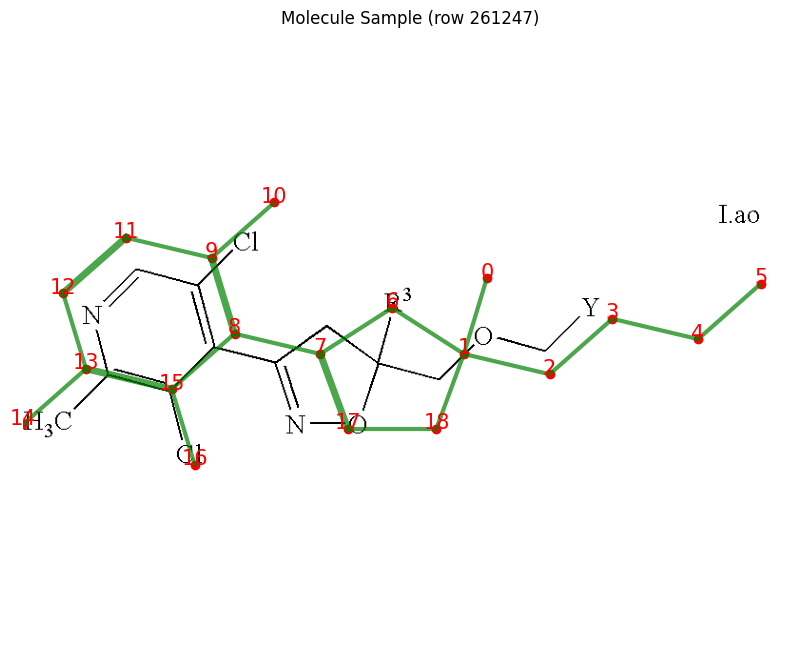

CC1=NC(C2=CC=C(Cl)C=C2)=NC=C1
uspto_mol/2006/I20060418/US07030128-20060418/US07030128-20060418-C00086.MOL


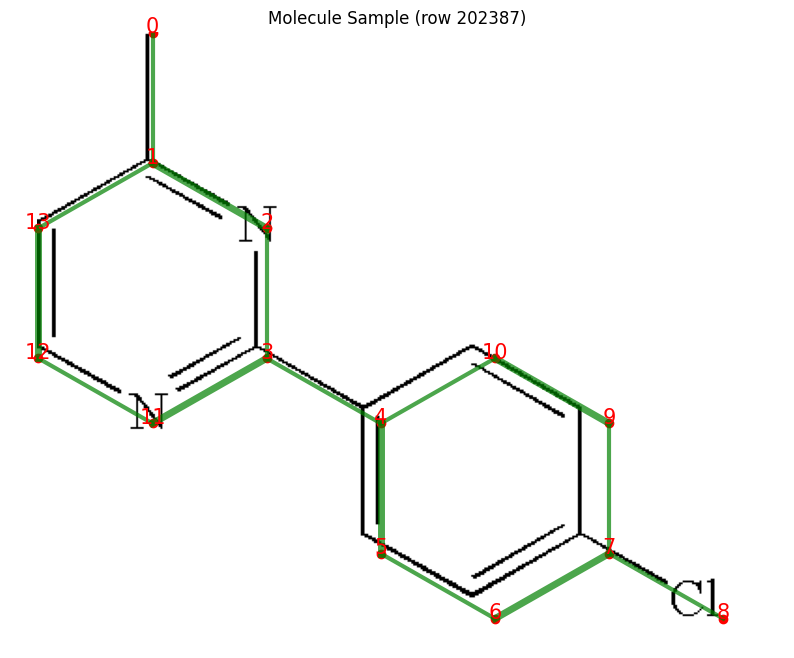

O=C1C2CCN(CC2)C1CN1C=NC2=C1N=CN=C2Cl
uspto_mol/2005/I20050726/US06921765-20050726/US06921765-20050726-C00003.MOL


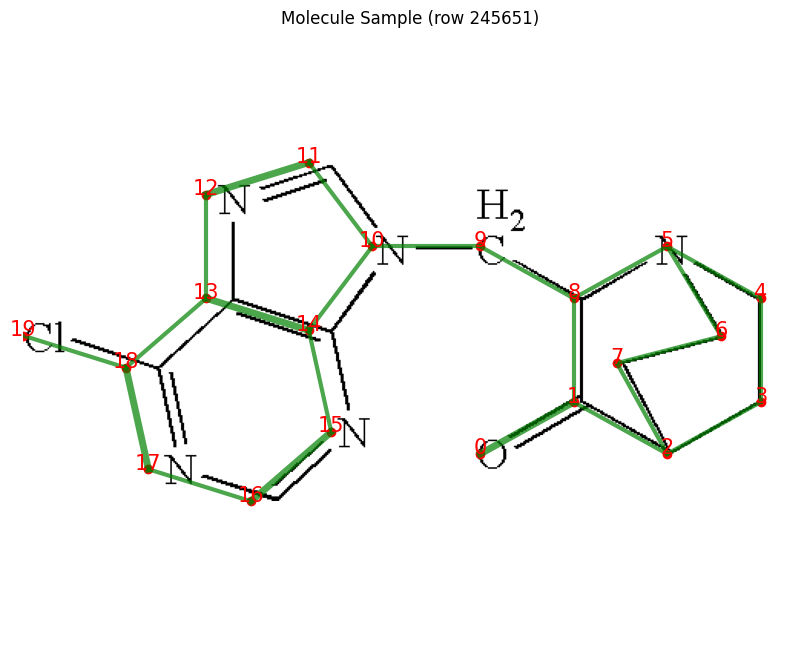

COC(=O)c1ccccc1OC(=O)Oc1ccccc1
uspto_mol/2002/20020625/US06410777-20020625/US06410777-20020625-C00037.MOL


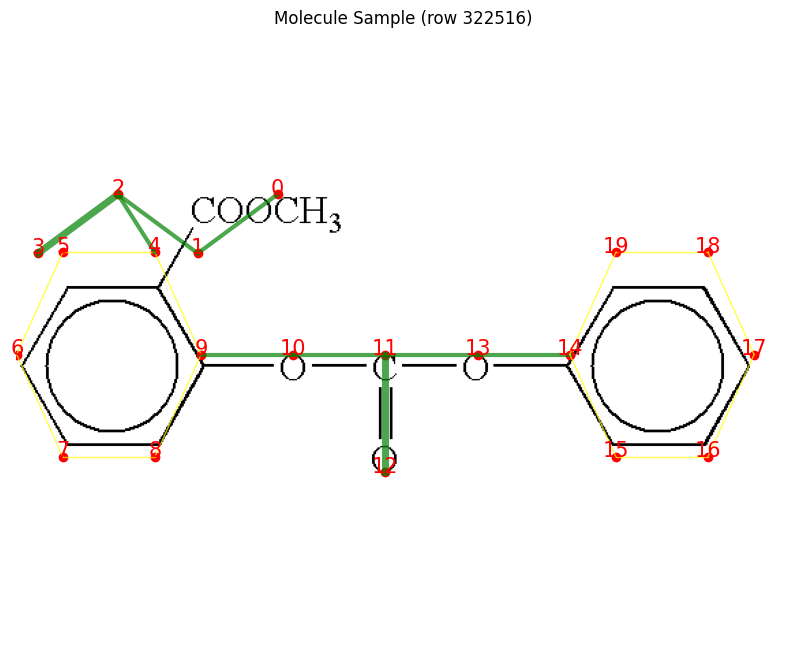

C=Cc1c(F)c(F)c(SC2=NN=C(Sc3c(F)c(F)c(C=C)c(F)c3F)S2)c(F)c1F
uspto_mol/2005/I20050510/US06891071-20050510/US06891071-20050510-C00002.MOL


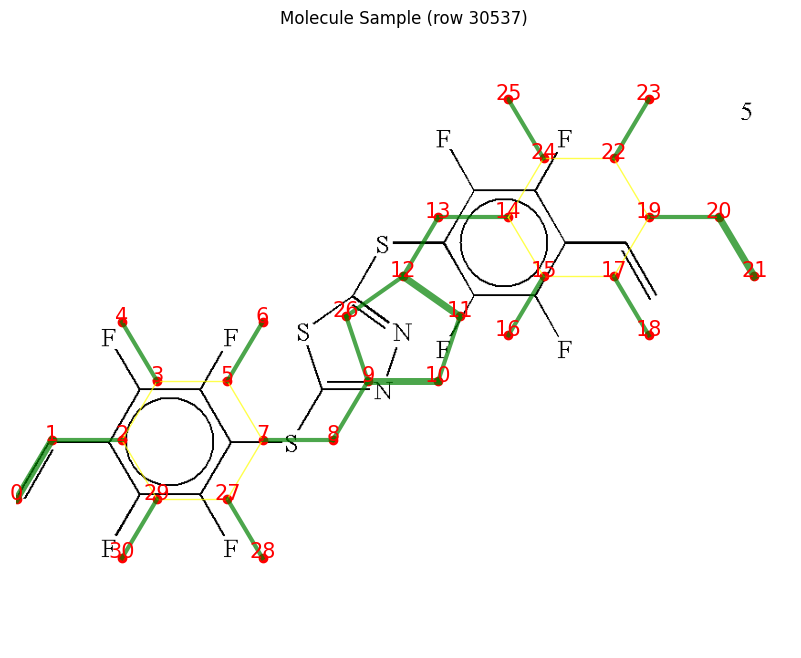

COC1=CC=C2NC(=O)C(Cl)(Cl)C2=C1Cl
uspto_mol/2006/I20060502/US07037909-20060502/US07037909-20060502-C00019.MOL


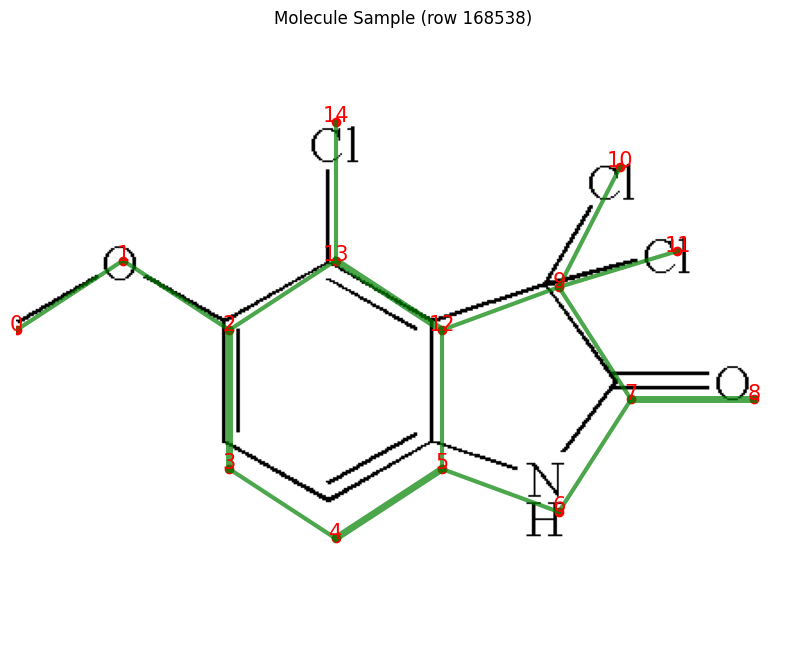

CCCCCCC(C)(C)C1=CC(OC)=C(C2(O)CC(=O)CC(C)C2)C(OC)=C1
uspto_mol/2007/I20070220/US07179800-20070220/US07179800-20070220-C00095.MOL


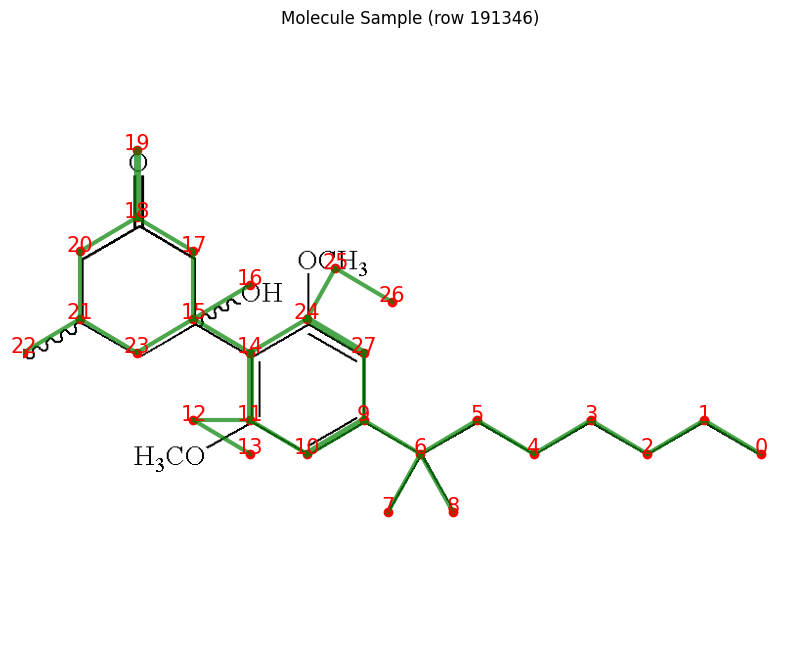

*C1=NC(Cl)=NC(Cl)=N1
uspto_mol/2003/20030722/US06596461-20030722/US06596461-20030722-C00008.MOL


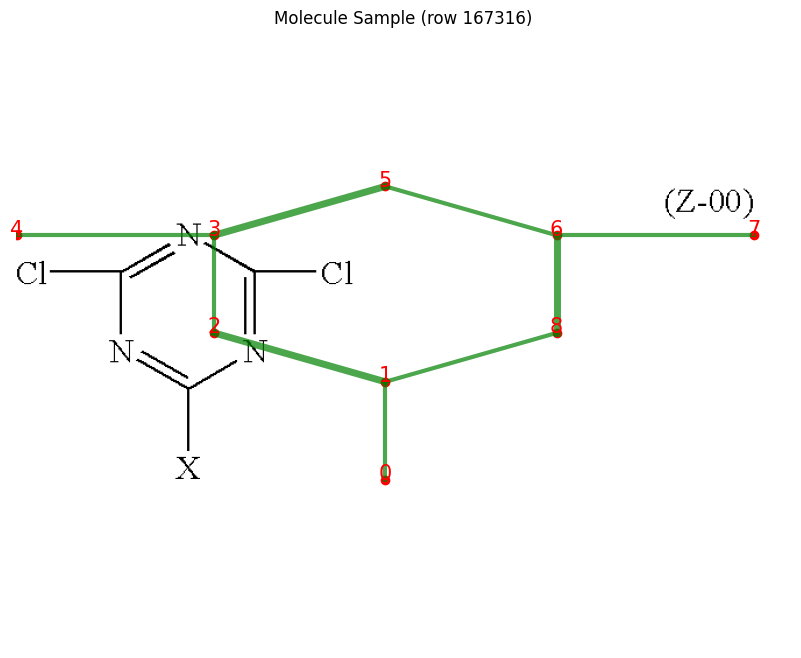

C=CC(C)CC(NC(=O)[C@@H]1[C@@H]2[C@H](CN1C(=O)C(NC(=O)OC(C)(C)C)(NC(=O)OC(C)(C)C)C(C)(C)C)C2(C)C)C(=O)C(=O)NCCS(=O)(=O)C(C)(C)C
uspto_mol/2007/I20070717/US07244721-20070717/US07244721-20070717-C02035.MOL


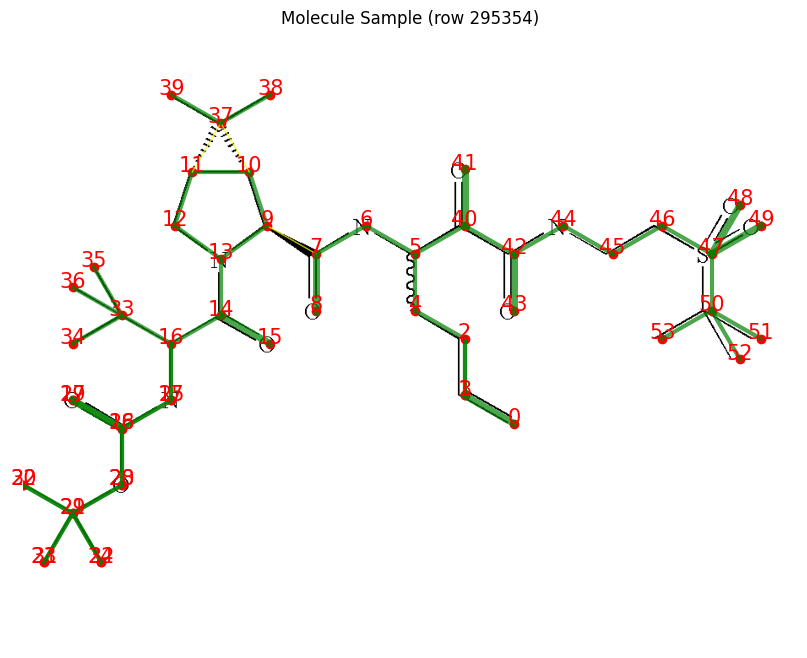

C=CC/C(=C/[Si](C)(C)[Si](C)(C)C1=CC=CC=C1)C1=CC=CC=C1
uspto_mol/2007/I20070807/US07253243-20070807/US07253243-20070807-C00010.MOL


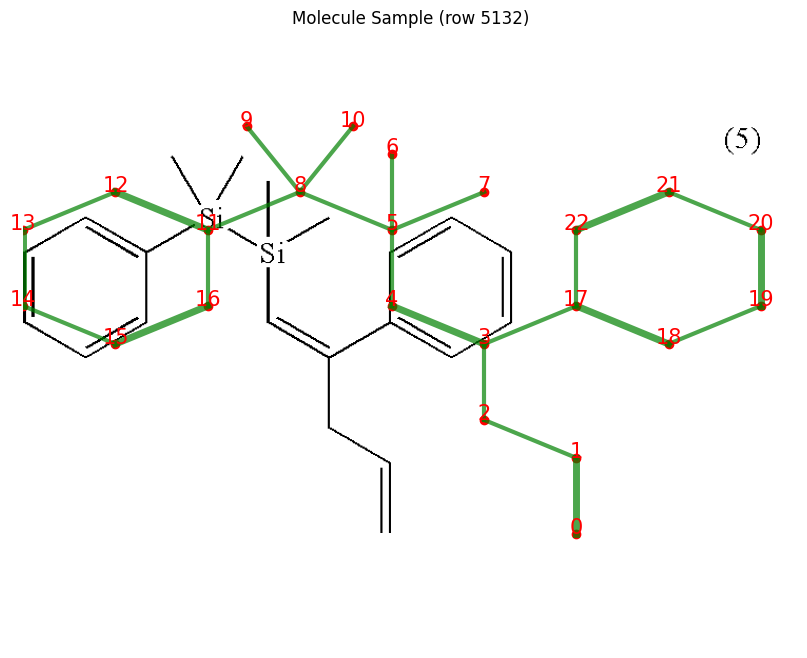

**N([5*])[C@H]1CC[C@]2(C)C3C[C@H]([1*])[C@@]4(C)C(CCC[C@@H]4C(C)CCC(=O)O)C3C([2*])C[C@]2([H])C1
uspto_mol/2002/20021112/US06479681-20021112/US06479681-20021112-C00013.MOL


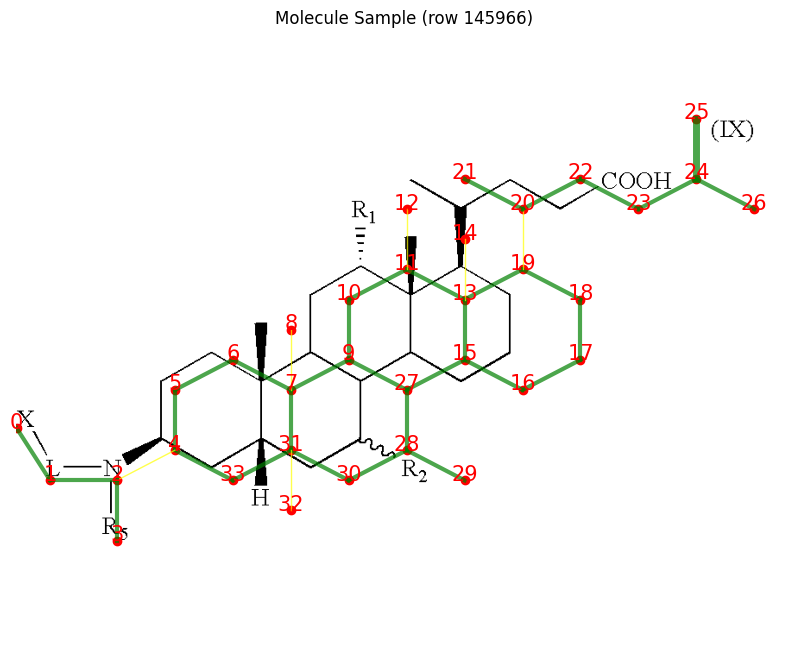

[2*]N([NHR1])C1([3*])C([4*])([5*])C2=C(C([9*])=C([8*])C([7*])=C2[6*])C1([10*])[OR11]
uspto_mol/2006/I20060103/US06982286-20060103/US06982286-20060103-C00001.MOL


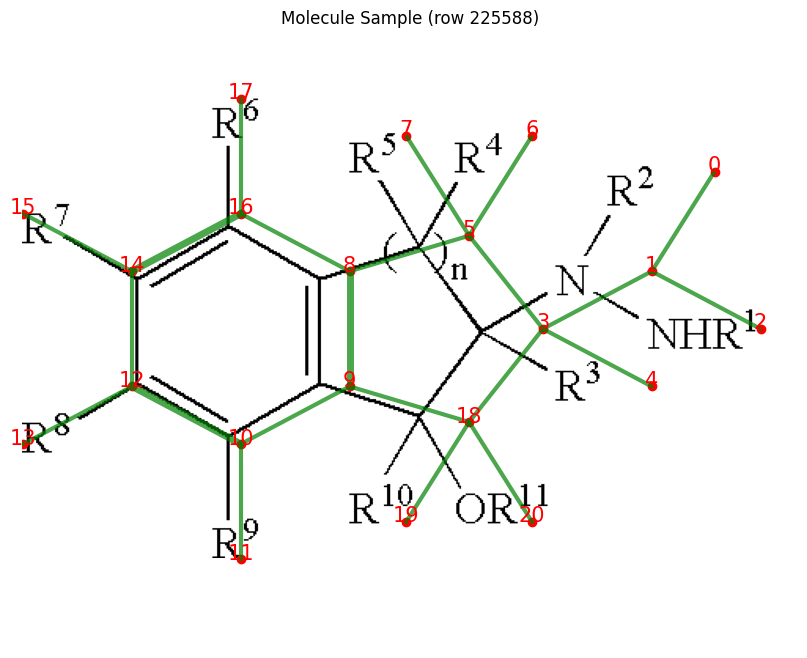

CC1=NN(c2ccccc2)C(O)=C1C
uspto_mol/2008/I20081007/US07432036-20081007/US07432036-20081007-C00127.MOL


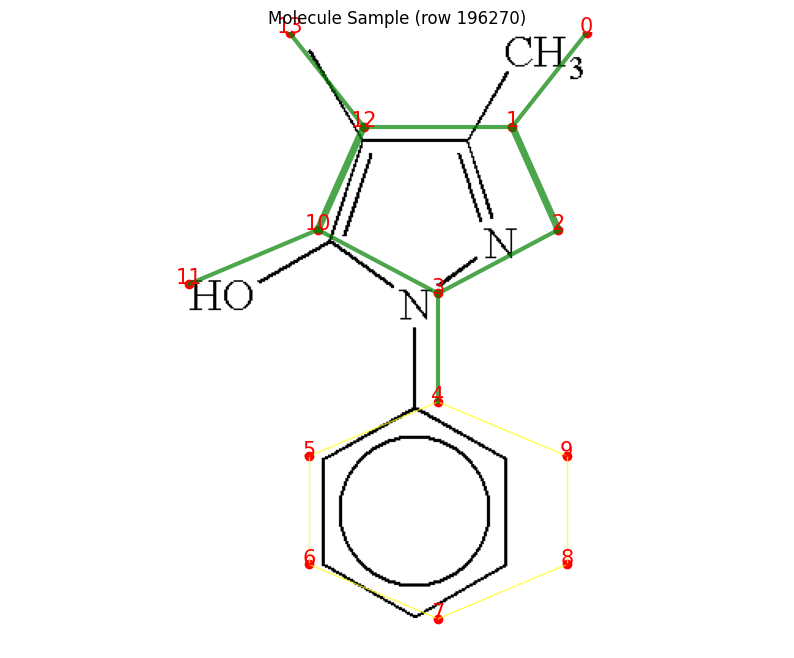

COC1=CC(C(=O)N2CCO[C@](CCN3CCC4(CC3)C3=C(C=CC=C3)C[S*]4[O-])(C3=CC(Cl)=C(Cl)C=C3)C2)=CC(OC)=C1OC
uspto_mol/2002/20020326/US06362179-20020326/US06362179-20020326-C00002.MOL


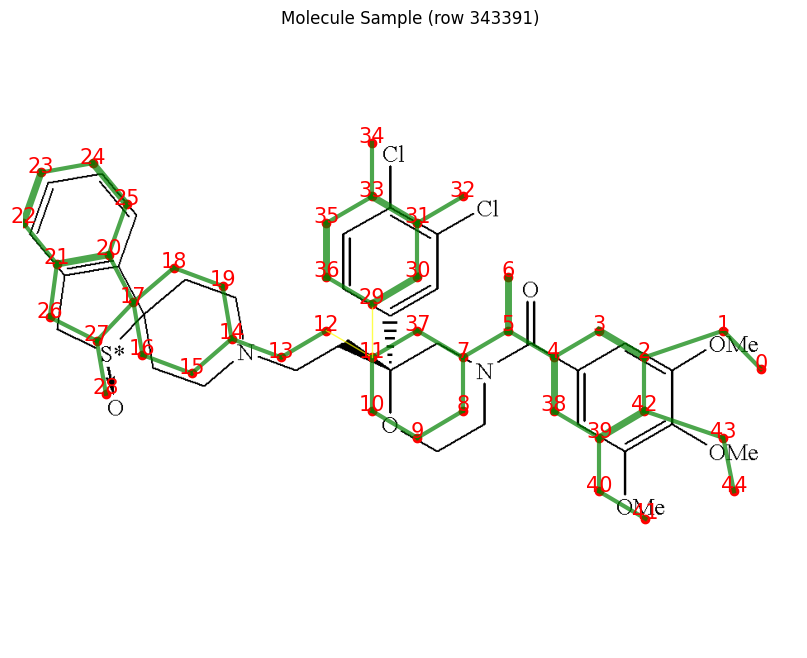

COC1=C(F)C=C(NC(=O)N2CCN(/C3=C/C=N\C4=CC(Cl)=CC=C43)CC2)C=C1
uspto_mol/2007/I20070522/US07220856-20070522/US07220856-20070522-C00018.MOL


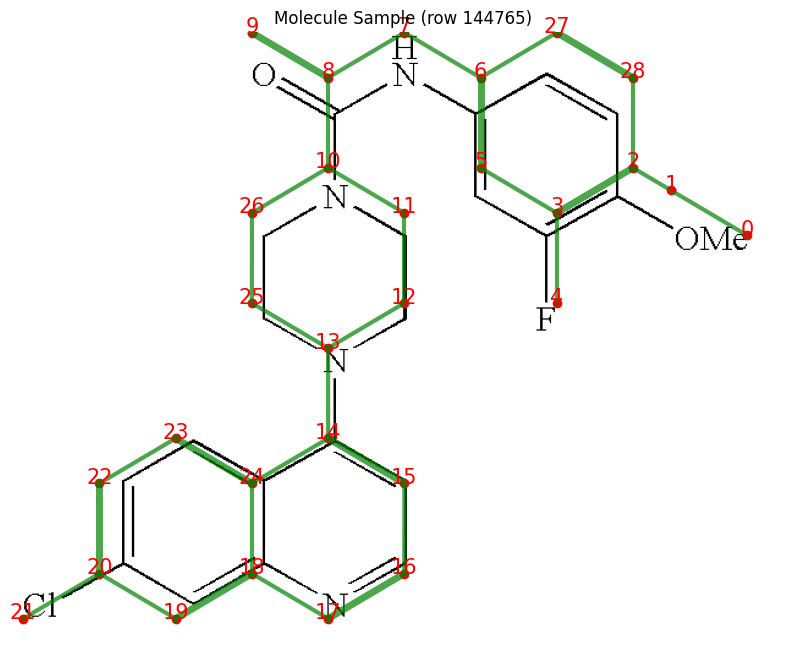

[NHBoc]C(=N)NOCCC(NC(=O)CN1C(=O)C(NS(=O)(=O)C2=CC(I)=CC=C2)=CC=C1C)C(=O)C1=NC2=C(C=CC=C2)S1
uspto_mol/2002/20020716/US06420397-20020716/US06420397-20020716-C00037.MOL


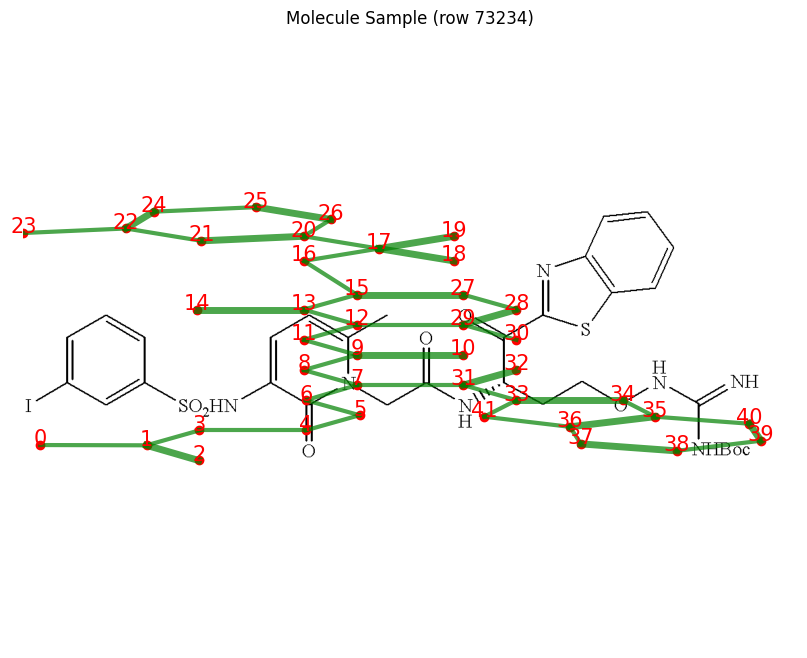

[1*]c1cc(C)cc([1*])c1O
uspto_mol/2004/20040803/US06770785-20040803/US06770785-20040803-C00002.MOL


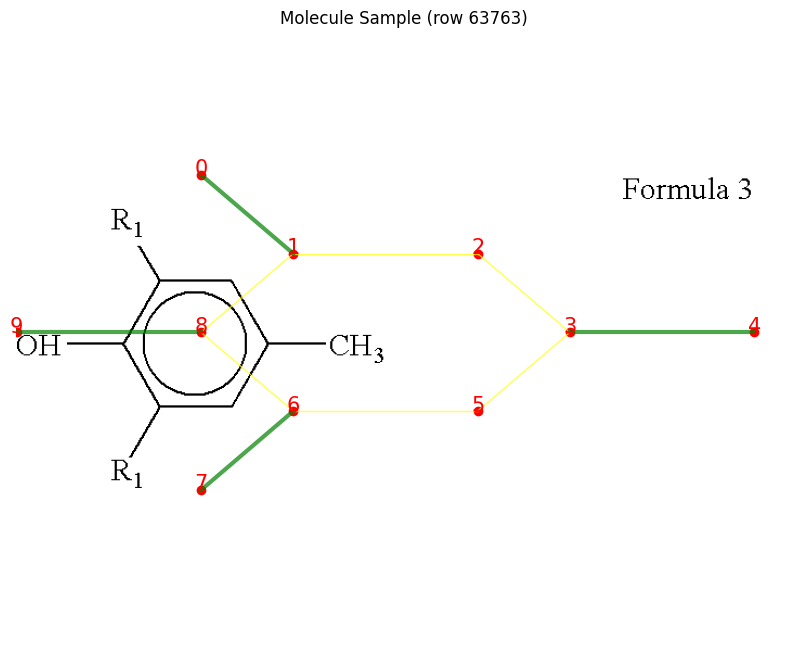

[H]N1CC[C@H]([(CH2)n][N+]#[C-])CCC1C(=O)NC(C(C)Cl)C1OC([SMe.])C(O)C(O)C1O
uspto_mol/2008/I20080422/US07361743-20080422/US07361743-20080422-C00331.MOL


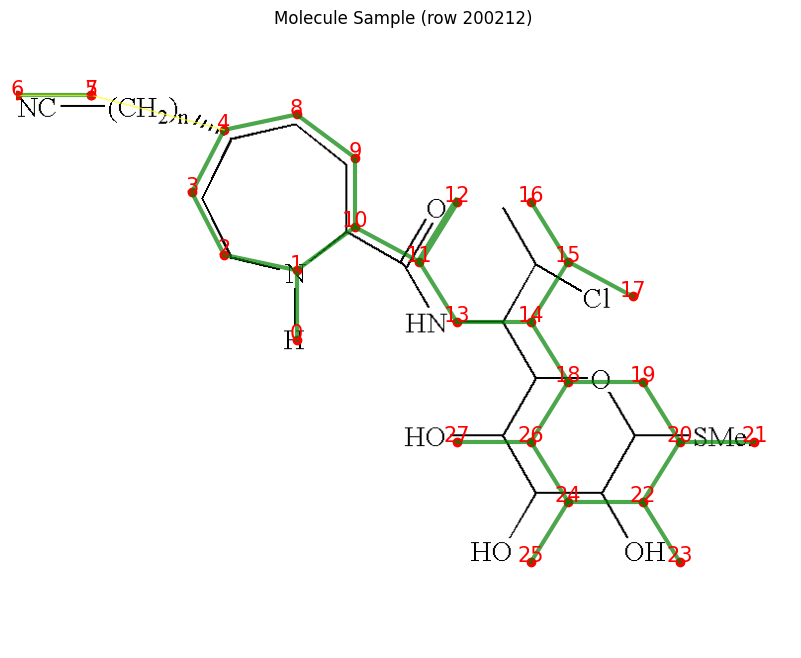

[H][C@]12CN(CC3=CC=C(Cl)C=C3)C(=O)[C@H](CN(C)C)N1C(=O)CCN2C(=O)NCC1=CC(C(F)(F)F)=CC([CF3])=C1
uspto_mol/2008/I20080318/US07345040-20080318/US07345040-20080318-C00309.MOL


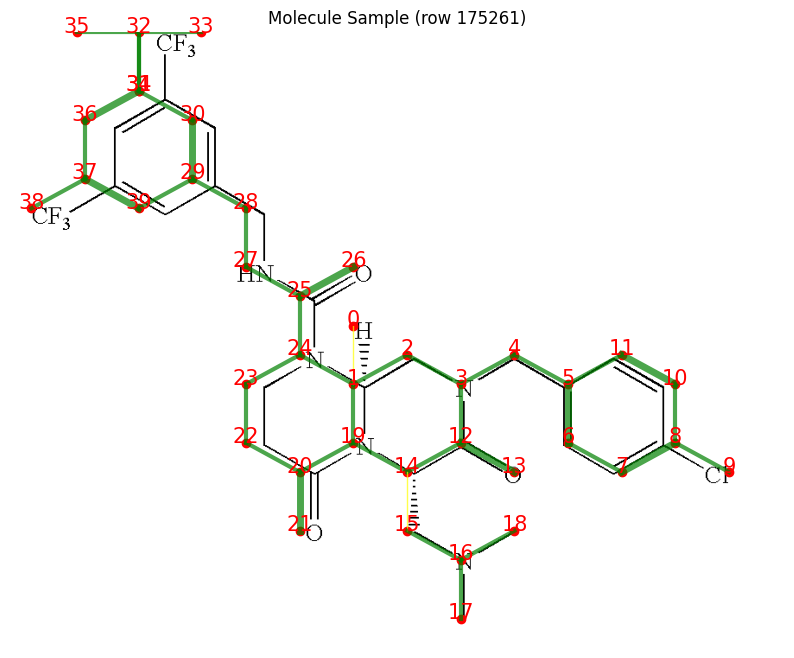

CC(C)[O-][Si](CCCCCC[Si]([O-]C(C)C)([O-]C(C)C)[O-]C(C)C)([O-]C(C)C)[O-]C(C)C
uspto_mol/2004/20041228/US06835520-20041228/US06835520-20041228-C00130.MOL


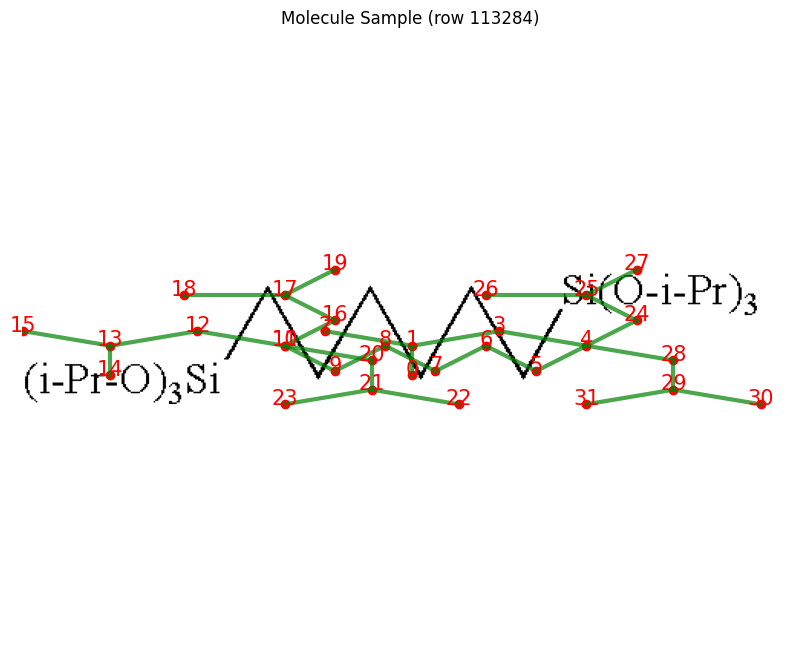

In [12]:

import matplotlib.pyplot as plt
from PIL import Image
df_samp = df.sample(30, random_state=42)
import ast
bond_styles = {
    1: {'linewidth': 3, 'color': 'green'},  # 단일 결합
    2: {'linewidth': 5, 'color': 'green'},    # 이중 결합 (굵게 표시)
}
for i, row in df_samp.iterrows():
    node_coords = row['node_coords']
    edges = row['edges']
    smiles = row['SMILES']
    image_path = row['file_path']
    mol_path = row['mol_path']
    # 문자열 리스트를 실제 리스트로 변환
    if isinstance(node_coords, str):
        node_coords = ast.literal_eval(node_coords)
    if isinstance(edges, str):
        edges = ast.literal_eval(edges)

    img = Image.open(image_path)



    # 이미지 크기 가져오기
    img_width, img_height = img.size

    # 노드 좌표를 이미지 크기에 맞게 스케일링
    scaled_coords = []
    for x, y in node_coords:
        # x, y를 이미지의 크기에 맞춰 0~1 범위로 정규화하고, 그 후 이미지 크기에 맞게 변환
        scaled_x = (x - min(x for x, y in node_coords)) / (max(x for x, y in node_coords) - min(x for x, y in node_coords)) * img_width
        # y축 반전 (이미지의 y좌표계와 맞추기 위해)
        scaled_y = (y - min(y for x, y in node_coords)) / (max(y for x, y in node_coords) - min(y for x, y in node_coords)) * img_height
        scaled_coords.append([scaled_x, img_height - scaled_y])  # y축 반전
   
    
    
    # 이미지에 그리기
    plt.figure(figsize=(10, 8))
    plt.imshow(img)


    # 노드 그리기
    for j, (x, y) in enumerate(scaled_coords):
         plt.plot(x, y, 'o', color='red')
         plt.text(x, y + 0.1, str(j), fontsize=15, ha='center', color='red')


    # 엣지 그리기
    # for start, end, bond_type in edges:
    #     x_vals = [scaled_coords[start][0], scaled_coords[end][0]]
    #     y_vals = [scaled_coords[start][1], scaled_coords[end][1]]
    #     style = bond_styles.get(bond_type, {'linewidth': 1, 'color': 'yellow'})
    #     plt.plot(x_vals, y_vals, linewidth=style['linewidth'], alpha = 0.5)
    for start, end, bond_type in edges:
        x_vals = [scaled_coords[start][0], scaled_coords[end][0]]
        y_vals = [scaled_coords[start][1], scaled_coords[end][1]]
        style = bond_styles.get(bond_type, {'linewidth': 1, 'color': 'yellow'})
        plt.plot(x_vals, y_vals, color=style['color'], linewidth=style['linewidth'], alpha=0.7)

    print(smiles)
    print(mol_path)
    plt.axis('equal')
    plt.axis('off')
    plt.title(f"Molecule Sample (row {i})")
    plt.show()


    



In [ ]:
# DFS 기반 edge 정렬 함수
def dfs_edge_sort(node_coords, edges):
    from collections import defaultdict

    # 1. 그래프 생성 (양방향)
    graph = defaultdict(list)
    for start, end, bond in edges:
        graph[start].append((end, bond))
        graph[end].append((start, bond))

    visited = set()
    sorted_edges = []
    used_edges = set()

    def dfs(node):
        visited.add(node)
        for neighbor, bond in graph[node]:
            edge = tuple(sorted([node, neighbor]) + [bond])
            if neighbor not in visited:
                if edge not in used_edges:
                    sorted_edges.append([node, neighbor, bond])
                    used_edges.add(edge)
                dfs(neighbor)
            else:
                # 방문된 노드지만, 아직 추가 안된 엣지 (뒤에서 오는 경우)
                if edge not in used_edges:
                    sorted_edges.append([node, neighbor, bond])
                    used_edges.add(edge)

    # 2. DFS 시작 (0번 노드부터)
    dfs(0)

    return sorted_edges

In [ ]:
#DFS 기반 엣지 정렬 확인하기
import ast

row = df_samp.iloc[0]
node_coords = ast.literal_eval(row['node_coords']) if isinstance(row['node_coords'], str) else row['node_coords']
edges = ast.literal_eval(row['edges']) if isinstance(row['edges'], str) else row['edges']

sorted_edges = dfs_edge_sort(node_coords, edges)

for edge in sorted_edges:
    print(edge)



[0, 1, 1]
[1, 2, 2]
[2, 3, 1]
[3, 4, 1]
[2, 5, 1]
[5, 6, 2]
[6, 7, 1]
[7, 8, 2]
[8, 1, 1]


In [107]:
df_samp.iloc[0]['node_coords']

'[[-0.7145,-0.6187],[-0.0,-0.2062],[-0.0,0.6187],[0.7145,-0.6187]]'

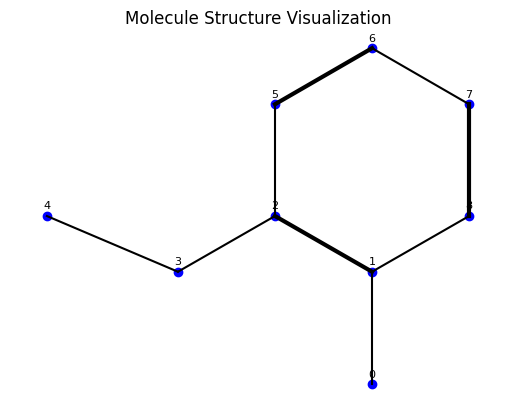

In [20]:
import matplotlib.pyplot as plt
bond_styles = {
    1: {'linewidth': 1.5, 'color': 'black'},  # 단일 결합
    2: {'linewidth': 3, 'color': 'black'},    # 이중 결합 (굵게 표시)
    # 필요하면 삼중 결합 등 추가 가능
}

# 노드 그리기
for i, (x, y) in enumerate(node_coords):
    plt.plot(x, y, 'o', color='blue')  # 노드를 파란색 원으로 표시
    plt.text(x, y+0.1, str(i), fontsize=8, ha='center')  # 노드 번호 표시

# 엣지 그리기
for start, end, bond_type in edges:
    x_values = [node_coords[start][0], node_coords[end][0]]
    y_values = [node_coords[start][1], node_coords[end][1]]
    style = bond_styles.get(bond_type, {'linewidth': 1, 'color': 'gray'})
    plt.plot(x_values, y_values, **style)

plt.axis('equal')
plt.axis('off')
plt.title("Molecule Structure Visualization")
plt.show()

[0, 1, 1]
[1, 2, 2]
[2, 3, 1]
[3, 4, 1]
[2, 5, 1]
[5, 6, 2]
[6, 7, 1]
[7, 8, 2]
[8, 1, 1]

# CoT 데이터셋 생성
- DFS 기반 edge sort
- 정렬된 edge, node 기반으로 cot 리스트 생성
- 엣지는 이전의 원자를 기반으로 예측됨

In [ ]:
import pandas as pd
import ast
import json
from collections import defaultdict
import re

def dfs_edge_sort(node_coords, edges):
    """
    DFS를 사용하여 엣지를 탐색 순서대로 정렬합니다.
    """
    graph = defaultdict(list)
    for start, end, bond in edges:
        graph[start].append((end, bond))
        graph[end].append((start, bond))

    visited = set()
    sorted_edges = []
    
    def dfs(node):
        visited.add(node)
        
        # 이웃 노드 ID 순으로 정렬하여 일관성 확보
        sorted_neighbors = sorted(graph[node], key=lambda x: x[0])
        
        for neighbor, bond in sorted_neighbors:
            if neighbor not in visited:
                sorted_edges.append([node, neighbor, bond])
                dfs(neighbor)
            # 순환 구조의 경우 이미 방문한 노드에 대한 엣지도 포함
            elif [node, neighbor, bond] not in sorted_edges and [neighbor, node, bond] not in sorted_edges:
                sorted_edges.append([node, neighbor, bond])

    if len(node_coords) > 0:
        dfs(0)
    
    return sorted_edges

def build_cot_from_sorted_edges(atom_list, node_coords, sorted_edges):
    """
    정렬된 엣지 리스트를 기반으로 COT 리스트를 생성합니다.
    """
    atom_dict = {i: {"a": atom_list[i], "id": i, "xy": node_coords[i]} for i in range(len(atom_list))}
    
    cot = []
    visited_atoms = set()
    
    # 첫 번째 원자를 COT에 추가 (항상 ID 0부터 시작)
    if len(atom_list) > 0:
        cot.append(atom_dict[0])
        visited_atoms.add(0)

    for start, end, bond in sorted_edges:
        # 두 번째 원자를 COT에 추가
        if end not in visited_atoms:
            cot.append(atom_dict[end])
            visited_atoms.add(end)
        
        # 결합 정보를 COT에 추가
        cot.append({"b": bond, "a1": start, "a2": end})
    
    return cot


def parse_atoms_from_mol_file(file_path):
    """
    Parses a V2000 MOL file to extract a list of atom symbols.

    This function reads a .mol file, extracts atom symbols from the atom block,
    and applies any replacements specified in the M END block.

    Args:
        file_path (str): The path to the .mol file.

    Returns:
        list: A list of atom symbols, or None if parsing fails.
    """
    atom_list = []
    atom_replacements = {}
    
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    # Get the number of atoms from the counts line (line 4)
    try:
        atom_count_line = lines[3]
        num_atoms = int(atom_count_line[0:3])
    except (IndexError, ValueError):
        return None

    # Parse Atom Block (lines 4 to 4 + num_atoms)
    # The atom symbol is located at character positions 31-34.
    for i in range(4, 4 + num_atoms):
        line = lines[i]
        atom_symbol = line[31:34].strip()
        atom_list.append(atom_symbol)

    # Parse M END Block for atom replacements
    # Substituent lines start with 'A '
    # Parse M END Block for atom replacements
    # Substituent lines start with 'A '
    for line in lines[4 + num_atoms:]:
        if line.startswith('A '):
            parts = line.split()
            # Add a check to ensure the list has enough elements
            if len(parts) >= 3:
                atom_idx = int(parts[1]) - 1  # MOL is 1-based
                replacement = parts[2]
                atom_replacements[atom_idx] = replacement
        
    # Apply replacements to the atom_list
    for idx, replacement in atom_replacements.items():
        if idx < len(atom_list):
            atom_list[idx] = replacement

    return atom_list

def create_conversation_row(image_path, atom_list, node_coords, edges, smiles, cot_list):
    conv = [
        {
            "from": "human",
            "value": (
                "<image> This is a schematic diagram of a chemical molecular structure. "
                "You are required to list the types of atomic elements in the diagram, the coordinates of the chemical bonds between all the atoms. "
                "In your predicted results, the type of bond is replaced by a number, with a single bond being 1, a double bond being 2, a triple bond being 3, "
                "an aromatic bond being 4, a solid wedge beding 5, and a dashed wedge being 6. displays the results in JSON format strictly following the format below. "
                "```json [ {\"a\":\"C\", \"id\":0, \"xy\":[x1, y1]}, {\"b\":1, \"a1\":0, \"a2\":1} ] ``` "
                "a means atom xy means coordinates, b means bond, a1 and a2 means the atom id of the bond. "
                "Them, based on the atoms and bonds that you have listed, output a canonical SMILES in JSON format with the key 'smiles'. Example format: "
                "```json { \"smiles\" : \"C1=CC=CC=C1\" } ``` Again, strictly follow the given format and do not add any extra explanations or content."
            )
        },
        {
            "from": "gpt",
            "value": json.dumps({
                "cot": cot_list,
                "smiles": smiles
            })
        }
    ]
    return {
        "image_path": image_path,
        "conversations": conv
    }

# --- 데이터셋 로드 및 처리 예시 ---
df = pd.read_csv('/workspace/uspto_mol/single_molecules.csv')
df_samp = df.sample(30, random_state=42)
result = []
for idx, row in df_samp.iterrows():  # 30개 데이터만 예시로 만들기
    image_path = row["file_path"]
    mol_path = row['mol_path']
    smiles = row["SMILES"]
    node_coords = ast.literal_eval(row["node_coords"])
    edges = ast.literal_eval(row["edges"])
    atom_list = parse_atoms_from_mol_file(mol_path)

    if len(atom_list) != len(node_coords):
        print(f"Skipping row {idx} due to mismatch.")
        continue
    
    # 1. 엣지를 DFS 순서로 정렬
    sorted_edges = dfs_edge_sort(node_coords, edges)
    
    # 2. 정렬된 엣지를 사용하여 COT 리스트 생성
    cot_list = build_cot_from_sorted_edges(atom_list, node_coords, sorted_edges)

    result.append(
        create_conversation_row(image_path, atom_list, node_coords, edges, smiles, cot_list)
    )

print(json.dumps(result, indent=2))

[
  {
    "image_path": "uspto_mol/2005/I20050104/US06838576-20050104/US06838576-20050104-C00001.TIF",
    "conversations": [
      {
        "from": "human",
        "value": "<image> This is a schematic diagram of a chemical molecular structure. You are required to list the types of atomic elements in the diagram, the coordinates of the chemical bonds between all the atoms. In your predicted results, the type of bond is replaced by a number, with a single bond being 1, a double bond being 2, a triple bond being 3, an aromatic bond being 4, a solid wedge beding 5, and a dashed wedge being 6. displays the results in JSON format strictly following the format below. ```json [ {\"a\":\"C\", \"id\":0, \"xy\":[x1, y1]}, {\"b\":1, \"a1\":0, \"a2\":1} ] ``` a means atom xy means coordinates, b means bond, a1 and a2 means the atom id of the bond. Them, based on the atoms and bonds that you have listed, output a canonical SMILES in JSON format with the key 'smiles'. Example format: ```json { \"

In [ ]:
output_file = 'uspto_cot_data.json'

# 1. 결과를 JSON 파일로 저장합니다.
try:
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(result, f, indent=2, ensure_ascii=False)
    print(f"결과가 '{output_file}' 파일에 성공적으로 저장되었습니다.\n")
except IOError as e:
    print(f"오류: 파일 '{output_file}'을(를) 저장할 수 없습니다. 이유: {e}")

# 2. 저장된 파일을 다시 읽어서 출력합니다.
try:
    with open(output_file, 'r', encoding='utf-8') as f:
        loaded_data = json.load(f)
    print("--- 저장된 파일의 내용 ---")
    print(json.dumps(loaded_data, indent=2, ensure_ascii=False))
except FileNotFoundError:
    print(f"오류: 파일 '{output_file}'을(를) 찾을 수 없습니다.")
except json.JSONDecodeError:
    print(f"오류: 파일 '{output_file}'이(가) 유효한 JSON 형식이 아닙니다.")

In [45]:
df = pd.read_pickle('/workspace/cot_data_V2/cot_data_V2/uspto_cot_train_data.pickle')
df.head()

,id,image_id,conversations,image
114476,0114476000,US07557106-20090707-C00031.png,"[{'from': 'human', 'value': '<image> This is a...",b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
35867,0035867000,US07381841-20080603-C00011.png,"[{'from': 'human', 'value': '<image> This is a...",b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
145217,0145217000,US06555541-20030429-C00037.png,"[{'from': 'human', 'value': '<image> This is a...",b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
76589,0076589000,US06689828-20040210-C00013.png,"[{'from': 'human', 'value': '<image> This is a...",b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
16596,0016596000,US06479227-20021112-C00066.png,"[{'from': 'human', 'value': '<image> This is a...",b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
